In [1]:
# Bermuda 2019 load in processed data and begin mode projection 
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy.io as si
from scipy.optimize import fmin
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import pickle
import datetime
import pickle
# functions I've written 
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

# matplotlib.rcParams['figure.figsize'] = (14,10)

# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 31.0
ref_lon = 69.5
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 45
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 3750  # 3900

In [2]:
# --- LOAD in initial processing results
# these include, raw profiles, velocity profiles, displacement profiles, background density profiles...
pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg037_2019_initial_processing.pkl', 'rb')
IP = pickle.load(pkl_file)
pkl_file.close()
ref_lon = IP['ref_lon']
ref_lat = IP['ref_lat']
grid = IP['depth']
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
grid_p[0] = 0
profile_tags = IP['raw_profile_tags']
sa = IP['sa']
ct = IP['ct']
gamma = IP['gamma']
prof_lon = IP['prof_lon']
prof_lat = IP['prof_lat']
prof_time = IP['profile_time']
# bckgrds = IP['background_indices']
# bckgrds_key = IP['background key']
# bd1 = IP['bd1']
# bd2 = IP['bd2']
lon_lim = IP['lon_lim']
lat_lim = IP['lat_lim']

N2 = IP['N2_by_season_quad']
sa_avg = IP['bckgrd_sa']
ct_avg = IP['bckgrd_ct']
theta_avg = IP['bckgrd_theta']
gamma_avg = IP['bckgrd_gamma']
mw_time = IP['mw_time']
mw_lon = IP['mw_lon']
mw_lat = IP['mw_lat']
mw_ct = IP['mw_ct']
mw_sa = IP['mw_sa']
mw_gamma = IP['mw_gamma']
mw_eta_1 = IP['eta_1']
mw_eta_2 = IP['eta_2']
mw_eta_3 = IP['eta_3']
eta_ind_1 = IP['eta_per_1']
eta_ind_3 = IP['eta_per_3']

mw_time_good = IP['mw_time_good']
gamma_good = IP['mw_gamma_good']
mw_eta_1_good = IP['eta_1_good']
mw_eta_2_good = IP['eta_2_good']
mw_eta_3_good = IP['eta_3_good']
box_side_info = IP['box_side_no']
mw_v_good = IP['dg_v_good']
mw_v_e_good = IP['dg_v_e_good']
mw_v_n_good = IP['dg_v_n_good']
mw_prof_good = IP['mw_prof_good']
PE_per_prof = IP['PE_per_prof']
PE_per_prof_time = IP['PE_per_prof_time']
PE_per_prof_tag = IP['PE_per_prof_tag']
# v_0 = IP['v_0']
# u_1 = IP['u_1']
# v_2 = IP['v_2']
# u_3 = IP['u_3']
u = IP['u_profiles']
u_no = IP['u_prof_no']
dace_u = IP['dac_e_u_profiles']
dacn_u = IP['dac_n_u_profiles']
v = IP['v_profiles']
v_no = IP['v_prof_no']
dace_v = IP['dac_e_v_profiles']
dacn_v = IP['dac_n_v_profiles']

t_s = datetime.date.fromordinal(np.int(np.nanmin(prof_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(prof_time)))

In [90]:
def x_triang(n):
    # TRIANG Triangular window.
    # W = TRIANG(N) returns the N-point triangular window.
    # Copyright 1988-2002 The MathWorks, Inc.
    # $Revision: 1.13 $  $Date: 2002/11/21 15:46:40 $
    if np.remainder(n,2):
        # It's an odd length sequence
        w1 = 2 * (np.arange(1, (n+2)/2)) / (n + 1)
        w2 = np.fliplr(w1[None, 0:-1])
        w = np.concatenate((np.transpose(w1[None,:]), np.transpose(w2)), axis=0)
        # w = 2*(1:(n+1)/2)/(n+1);
        # w = [w w((n-1)/2:-1:1)]';
    else:
        # It's even
        w1 = 2 * (np.arange(1, (n+1)/2)) / n
        w2 = np.fliplr(w1[None, 0:-1])
        w = np.concatenate((np.transpose(w1[None,:]), np.transpose(w2)), axis=0)
        # w = (2*(1:(n+1)/2)-1)/n;
        # w = [w w(n/2:-1:1)]';
    return (w)    

def trifilt(x, n):    
    def x_triang(n):
        # TRIANG Triangular window.
        # W = TRIANG(N) returns the N-point triangular window.
        # Copyright 1988-2002 The MathWorks, Inc.
        # $Revision: 1.13 $  $Date: 2002/11/21 15:46:40 $
        if np.remainder(n,2):
            # It's an odd length sequence
            w1 = 2 * (np.arange(1, (n+2)/2)) / (n + 1)
            w2 = np.fliplr(w1[None, 0:-1])
            w = np.concatenate((np.transpose(w1[None,:]), np.transpose(w2)), axis=0)
            # w = 2*(1:(n+1)/2)/(n+1);
            # w = [w w((n-1)/2:-1:1)]';
        else:
            # It's even
            w1 = 2 * (np.arange(1, (n+1)/2)) / n
            w2 = np.fliplr(w1[None, 0:-1])
            w = np.concatenate((np.transpose(w1[None,:]), np.transpose(w2)), axis=0)
            # w = (2*(1:(n+1)/2)-1)/n;
            # w = [w w(n/2:-1:1)]';
        return w      
    
    # xf is x filtered with a triangular filter of half-width n
    # xf has the same length as x so that features in xf and x 
    # line up.  Endpoints are corrected by filter area so that 
    # effective filter area is half at the endpoints and progressively
    # increases to unity 2*n points from the ends of the series x
    m = len(x)
    g = x_triang(2*n-1)/n 
    y = np.convolve(x, g[:, 0]);
    s = len(y)
    xf = y[np.int((s-m)/2 + 1):np.int((s-m)/2 + m + 1)]
    uu = np.ones((m,1))
    vv = np.convolve(uu[:, 0], g[:, 0])
    uu = vv[ np.int((s-m)/2 + 1):np.int((s-m)/2 + m + 1)]
    xf = xf/uu
    return xf

In [81]:
x = u[:, 0].copy()
m = len(x)
n = 50
g = x_triang(2*n-1)/n 
y = np.convolve(x, g[:, 0]);
s = len(y)
xf = y[np.int((s-m)/2 + 1):np.int((s-m)/2 + m + 1)]
uu = np.ones((m,1))
vv = np.convolve(uu[:, 0], g[:, 0])
uu = vv[ np.int((s-m)/2 + 1):np.int((s-m)/2 + m + 1)]
xf = xf/uu

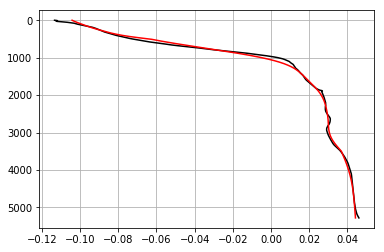

()

In [91]:
u_filt = trifilt(u[:, 0], 50)
f, ax = plt.subplots()
ax.plot(u[:, 0], grid, color='k')
ax.plot(u_filt, grid, color='r')
ax.invert_yaxis()
plot_pro(ax)

In [3]:
np.shape(mw_time_good)
print(mw_prof_good)
print(u_no)
print(v_no)
time_order_i = np.argsort(mw_time_good)
mw_time_order = mw_time_good[time_order_i]
mw_prof_order = mw_prof_good[time_order_i]
mw_eta_3_order = mw_eta_3_good[:, time_order_i]
u_time = np.nan * np.ones(len(u_no))
v_time = np.nan * np.ones(len(v_no))
# order u, v velocities and pair with times 
for i in range(len(u_no)):
    indi = np.where(mw_prof_order == u_no[i])[0]
    u_time[i] = mw_time_order[indi]  
for i in range(len(v_no)):
    indi = np.where(mw_prof_order == v_no[i])[0]
    v_time[i] = mw_time_order[indi]      

[  55.5   56.    56.5   67.5   68.    68.5   81.5   82.    82.5   96.5
   97.    97.5   98.    98.5  110.5  111.   111.5  122.5  123.   123.5
   46.5   47.    47.5   58.5   59.    59.5   70.5   71.    71.5   72.
   72.5   84.5   85.    85.5   86.    86.5   87.    87.5  100.5  101.
  101.5  102.   102.5  113.5  125.5  126.   126.5   52.5   53.    53.5
   64.5   65.    65.5   77.5   78.    78.5   79.    79.5   92.5   93.
   93.5   94.    94.5  107.5  108.   108.5  118.5  119.   119.5  120.
  120.5  131.5   49.5   50.    50.5   61.5   62.    62.5   74.5   75.
   75.5   89.5   90.    90.5  104.5  105.   105.5  115.5  116.   116.5
  128.5  129.   129.5]
[  49.5   50.    50.5   55.5   56.    56.5   61.5   62.    62.5   67.5
   68.    68.5   74.5   75.    75.5   81.5   82.    82.5   89.5   90.
   90.5   96.5   97.    97.5   98.    98.5  104.5  105.   105.5  110.5
  111.   111.5  115.5  116.   116.5  122.5  123.   123.5  128.5  129.
  129.5]
[  46.5   47.    47.5   52.5   53.    53.5   58.5   

In [8]:
print(u_no[25])
print(v_no[33])
print(u_no[28])  # 34
print(v_no[38])  # 47

98.5
94.5


In [4]:
# --- EOFs (eigenvalue problem) of glider and model velocity profiles
check1 = 7      # upper index to include in eof computation
check2 = -14     # lower index to include in eof computation
grid_sub_i = range(7, len(grid)-12)  # [10, 50, 100, 150, 200, 250, 300, 350, 400, 450]
grid_check = grid[grid_sub_i]
not_shallow = np.isfinite(u[-30, :])
not_shallow = np.isfinite(v[-30, :])

# --- glider u           
Uzq = u[grid_sub_i, :].copy()
nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)
t1 = np.real(D_Uzqa[0:10])
PEV = t1 / np.sum(t1)
eof1 = np.real(D_Uzqa[0])*np.squeeze(np.array(np.real(V_Uzqa[:, 0])))
eof2 = np.real(D_Uzqa[1])*np.squeeze(np.array(np.real(V_Uzqa[:, 1])))

# --- glider v            
Uzq = v[grid_sub_i, :].copy()
nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
Dv_Uzqa, Vv_Uzqa = np.linalg.eig(cov_Uzqa)
t1 = np.real(Dv_Uzqa[0:10])
PEVv = t1 / np.sum(t1)
eof1v = np.real(Dv_Uzqa[0])*np.squeeze(np.array(np.real(Vv_Uzqa[:, 0])))
eof2v = np.real(Dv_Uzqa[1])*np.squeeze(np.array(np.real(Vv_Uzqa[:, 1])))

# --- glider all velocities
grid_sub_i_2 = grid_sub_i 
# [10, 30, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450]
uv_times = np.concatenate((u_time, v_time), axis=0)
uv_times_ordered = np.argsort(uv_times)
uv_comb = np.concatenate((u[grid_sub_i_2, :], v[grid_sub_i_2, :]), axis=1)
Uzq = uv_comb[:, uv_times_ordered]
nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
cov_Uzqa_all = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
D_Uzqa_all, V_Uzqa_all = np.linalg.eig(cov_Uzqa_all)
t1_all = np.real(D_Uzqa_all[0:10])
PEV_all = t1_all / np.sum(t1_all)
eof1_all = np.real(D_Uzqa_all[0])*np.squeeze(np.array(np.real(V_Uzqa_all[:, 0])))
eof2_all = np.real(D_Uzqa_all[1])*np.squeeze(np.array(np.real(V_Uzqa_all[:, 1])))

In [5]:
# svd (should yeild same result as solution to eig)
# --- glider eta    
grid_sub_i_eta = range(10, len(grid)-20)
grid_check_eta = grid[grid_sub_i_eta]
etazq = np.concatenate((eta_ind_3[grid_sub_i_eta, 0:76], eta_ind_3[grid_sub_i_eta, 77:]), axis=1)
eta_ind_time = np.concatenate((prof_time[0:76], prof_time[77:]), axis=0)
# eta_ind_3[grid_sub_i_eta, :].copy()
nq = np.size(etazq[0, :])
avg_etazq = np.nanmean(np.transpose(etazq), axis=0)
data_eta = etazq - np.transpose(np.tile(avg_etazq, [nq, 1]))
[UUe, SSe, VVe] = np.linalg.svd(data_eta, full_matrices=False, compute_uv=True)

p = np.min([np.shape(data_eta)[0], np.shape(data_eta)[1]])
Spe=SSe[0:p];
lambe=np.matrix(Spe[:, None])*np.transpose(np.matrix(Spe[:, None]));
var_eta=np.trace(lambe);
frac_eof_eta=np.diag(lambe)/var_eta;

# --- glider u           
Uzq = u[grid_sub_i, :].copy()
nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
data = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
[UU, SS, VV] = np.linalg.svd(data, full_matrices=False, compute_uv=True)
p = np.min([np.shape(data)[0], np.shape(data)[1]])
Sp=SS[0:p];
lamb=np.matrix(Sp[:, None])*np.transpose(np.matrix(Sp[:, None]));
var_u=np.trace(lamb);
frac_eof=np.diag(lamb)/var_u;

# --- glider v           
Vzq = v[grid_sub_i, :].copy()
nq_v = np.size(Vzq[0, :])
avg_Vzq = np.nanmean(np.transpose(Vzq), axis=0)
data_V = Vzq - np.transpose(np.tile(avg_Vzq, [nq_v, 1]))
[UU2, SS2, VV2] = np.linalg.svd(data_V, full_matrices=False, compute_uv=True)
p2 = np.min([np.shape(data_V)[0], np.shape(data_V)[1]])
Sp2=SS2[0:p2];
lamb2=np.matrix(Sp2[:, None])*np.transpose(np.matrix(Sp2[:, None]));
var_v=np.trace(lamb2);
frac_eof_v=np.diag(lamb2)/var_v;

# --- glider u, v       
UVzq = uv_comb[:, uv_times_ordered].copy()
nq_uv = np.size(UVzq[0, :])
avg_UVzq = np.nanmean(np.transpose(UVzq), axis=0)
data_UV = UVzq - np.transpose(np.tile(avg_UVzq, [nq_uv, 1]))
[UU3, SS3, VV3] = np.linalg.svd(data_UV, full_matrices=False, compute_uv=True)
p3 = np.min([np.shape(data_UV)[0], np.shape(data_UV)[1]])
Sp3=SS3[0:p3];
lamb3=np.matrix(Sp3[:, None])*np.transpose(np.matrix(Sp3[:, None]));
var_uv=np.trace(lamb3);
frac_eof_uv=np.diag(lamb3)/var_uv;

# amplitude from SVD (compare to amplitude from eig)
Amp1_eta = VVe[0, :]*SSe[0]
Amp1_u = (VV[0, :]*SS[0])**2

Uzq = u[grid_sub_i, :].copy()
nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
Amp1_u_eig = np.nansum(Uzqa[:, 20]*V_Uzqa[:, 0])**2
print(Amp1_u[20])
print(np.real(Amp1_u_eig))
# yes it works! they are the same (seems like SVD is computationally faster)

0.151851986015
0.151851986015


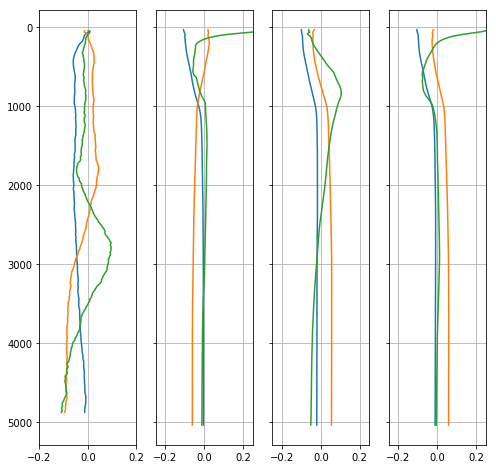

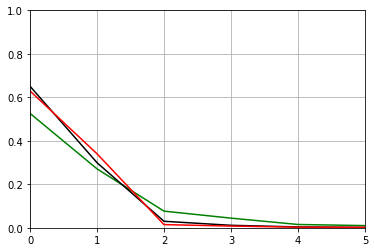

()

In [6]:
# plotting 
matplotlib.rcParams['figure.figsize'] = (8, 8)
f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, sharey=True)
ax0.plot(UUe[:, 0], grid_check_eta)
ax0.plot(UUe[:, 1], grid_check_eta)
ax0.plot(UUe[:, 2], grid_check_eta)
ax0.grid()
ax0.invert_yaxis()
ax1.plot(UU[:, 0], grid_check)
ax1.plot(UU[:, 1], grid_check)
ax1.plot(UU[:, 2], grid_check)
ax1.grid()
ax2.plot(UU2[:, 0], grid_check)
ax2.plot(UU2[:, 1], grid_check)
ax2.plot(UU2[:, 2], grid_check)
ax2.grid()
ax3.plot(UU3[:, 0], grid[grid_sub_i_2])
ax3.plot(UU3[:, 1], grid[grid_sub_i_2])
ax3.plot(UU3[:, 2], grid[grid_sub_i_2])
ax0.set_xlim([-.2, .2])
ax1.set_xlim([-.25, .25])
ax2.set_xlim([-.25, .25])
ax3.set_xlim([-.25, .25])
plot_pro(ax3)

matplotlib.rcParams['figure.figsize'] = (6, 4)
f, ax = plt.subplots()
ax.plot(np.arange(0, len(frac_eof_eta)), frac_eof_eta, color='g')
ax.plot(np.arange(0, len(frac_eof)), frac_eof, color='k')
ax.plot(np.arange(0, len(frac_eof_v)), frac_eof_v, color='r')
ax.set_ylim([0, 1])
ax.set_xlim([0, 5])
plot_pro(ax)

In [9]:
np.shape(u)

(490, 29)

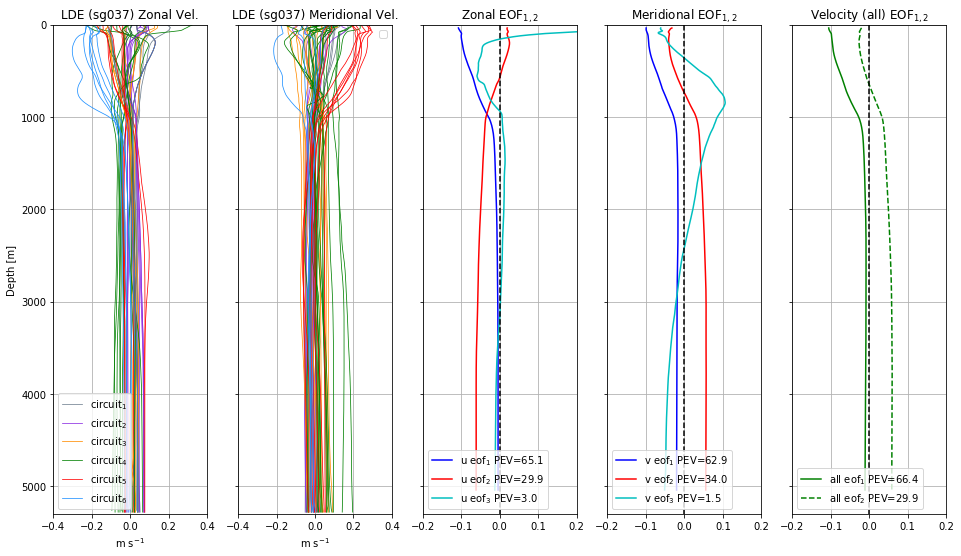

In [8]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
f, (ax0, ax05, ax, ax2, ax3) = plt.subplots(1, 5, sharey=True)

for i in range(np.shape(u)[1]):
    if i <= 5:
        ax0.plot(u[:, i], grid, color='#708090', linewidth=0.75)
    elif (i > 5) & (i <= 11):
        ax0.plot(u[:, i], grid, color='#8A2BE2', linewidth=0.75)
    elif (i > 11) & (i <= 17):
        ax0.plot(u[:, i], grid, color='#FF8C00', linewidth=0.75)    
    elif (i > 17) & (i <= 28):
        ax0.plot(u[:, i], grid, color='g', linewidth=0.75)  
    elif (i > 28) & (i <= 34):
        ax0.plot(u[:, i], grid, color='r', linewidth=0.75)          
    else: 
        ax0.plot(u[:, i], grid, color='#1E90FF', linewidth=0.75)
ax0.plot(u[:, 0], grid, color='#708090', linewidth=0.75, label=r'circuit$_1$')
ax0.plot(u[:, 7], grid, color='#8A2BE2', linewidth=0.75, label=r'circuit$_2$')
ax0.plot(u[:, 15], grid, color='#FF8C00', linewidth=0.75, label=r'circuit$_3$')
ax0.plot(u[:, 18], grid, color='g', linewidth=0.75, label=r'circuit$_4$')
ax0.plot(u[:, 26], grid, color='r', linewidth=0.75, label=r'circuit$_5$')
ax0.plot(u[:, 26], grid, color='#1E90FF', linewidth=0.75, label=r'circuit$_6$')
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=10)
ax0.set_title('LDE (sg037) Zonal Vel.')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel(r'm s$^{-1}$')
ax0.grid()   
ax0.set_ylim([0, 5200])
ax0.set_xlim([-.4, .4])
for j in range(np.shape(v)[1]):
    if j <= 5: 
        ax05.plot(v[:, j], grid, color='#708090', linewidth=0.75)  
    elif (j > 5) & (j <= 11):
        ax05.plot(v[:, j], grid, color='#8A2BE2', linewidth=0.75)
    elif (j > 11) & (j <= 21):
        ax05.plot(v[:, j], grid, color='#FF8C00', linewidth=0.75)    
    elif (j > 21) & (j <= 38):
        ax05.plot(v[:, j], grid, color='g', linewidth=0.75) 
    elif (j > 38) & (j <= 47):
        ax05.plot(v[:, j], grid, color='r', linewidth=0.75)     
    else:
        ax05.plot(v[:, j], grid, color='#1E90FF', linewidth=0.75)
# ax05.plot(v[:, j], grid, color='g', linewidth=0.5, label='v') 
handles, labels = ax05.get_legend_handles_labels()
ax05.legend(handles, labels, fontsize=10)
ax05.set_title('LDE (sg037) Meridional Vel.')
ax05.set_xlabel(r'm s$^{-1}$')
ax05.grid()   
ax05.set_ylim([0, 5300])
ax05.set_xlim([-.4, .4])

ax.plot(UU[:, 0], grid_check, label=r'u eof$_1$ PEV=' + str(np.round(frac_eof[0]*100,1)), color='b')
ax.plot(UU[:, 1], grid_check, linestyle='-', label=r'u eof$_2$ PEV=' + str(np.round(frac_eof[1]*100,1)), color='r')
ax.plot(UU[:, 2], grid_check, linestyle='-', label=r'u eof$_3$ PEV=' + str(np.round(frac_eof[2]*100,1)), color='c')
ax.plot([0, 0], [0, 5500], color='k', linewidth=1.5, linestyle='--')

ax2.plot(UU2[:, 0], grid_check, label=r'v eof$_1$ PEV=' + str(np.round(frac_eof_v[0]*100,1)), color='b')
ax2.plot(UU2[:, 1], grid_check, linestyle='-', label=r'v eof$_2$ PEV=' + str(np.round(frac_eof_v[1]*100,1)), color='r')
ax2.plot(UU2[:, 2], grid_check, linestyle='-', label=r'v eof$_3$ PEV=' + str(np.round(frac_eof_v[2]*100,1)), color='c')
ax2.plot([0, 0], [0, 5500], color='k', linewidth=1.5, linestyle='--')

ax3.plot(UU3[:, 0], grid[grid_sub_i_2], label=r'all eof$_1$ PEV=' + str(np.round(frac_eof_uv[0]*100,1)), color='g')
ax3.plot(UU3[:, 1], grid[grid_sub_i_2], linestyle='--', label=r'all eof$_2$ PEV=' + str(np.round(frac_eof_uv[1]*100,1)), color='g')
ax3.plot([0, 0], [0, 5500], color='k', linewidth=1.5, linestyle='--')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=10)
ax.set_title(r'Zonal EOF$_{1,2}$')
ax2.set_title(r'Meridional EOF$_{1,2}$')
ax3.set_title(r'Velocity (all) EOF$_{1,2}$')
ax.invert_yaxis()
ax.set_xlim([-.2, .2])
ax2.set_xlim([-.2, .2])
ax3.set_xlim([-.2, .2])
ax.grid()
ax2.grid()
plot_pro(ax3)
f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/sg037_19_uv_eof.jpg", dpi=400)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


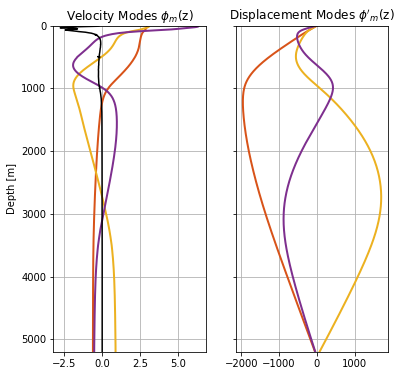

()

In [9]:
# --- VERTICAL MODES ---
# --- compute vertical mode shapes
# bckgrds_info = ['Win_1', 'Win_2', 'Win_3', 'Win_4', 'Sum_1', 'Sum_2', 'Sum_3', 'Sum_4',
#                 'Fall_1', 'Fall_2', 'Fall_3', 'Fall_4']
# N2 order = 
# G_0, Gz_0, c_0, epsilon_0 = vertical_modes(np.nanmean(N2[:, 0:4], axis=1), grid, omega, mmax)  # winter
# G_1, Gz_1, c_1, epsilon_1 = vertical_modes(np.nanmean(N2[:, 4:8], axis=1), grid, omega, mmax)  # summer
# G_2, Gz_2, c_2, epsilon_2 = vertical_modes(np.nanmean(N2[:, 8:], axis=1), grid, omega, mmax)  # fall
# Gs = [G_0, G_1, G_2]
# Gzs = [Gz_0, Gz_1, Gz_2]
# cs = [c_0, c_1, c_2]
# epsilons = [epsilon_0, epsilon_1, epsilon_2]
# test using average over entire year
N2_all = np.nanmean(N2, axis=1)
G_tot, Gz_tot, c_tot, epsilon_tot = vertical_modes(N2_all, grid, omega, mmax)  # N2

# --- compute alternate vertical modes (allowing for a sloping bottom)
bc_bot = 1  # 1 = flat, 2 = rough
slope = 3.0*10**(-2)  # 5.0*10**(-2)
grid2 = np.concatenate([np.arange(0, 150, 10), np.arange(150, 300, 10), np.arange(300, 4500, 10)])
n2_interp = np.interp(grid2, grid, N2_all)
n2_interp[0] = n2_interp[1] - 0.000001
F_int_g2, F_g2, c_ff, norm_constant, epsilon2 = vertical_modes_f(n2_interp, grid2, omega, mmax, bc_bot, ref_lat, slope)
F = np.nan * np.ones((np.size(grid), mmax + 1))
F_int = np.nan * np.ones((np.size(grid), mmax + 1))
for i in range(mmax + 1):
    F[:, i] = np.interp(grid, grid2, F_g2[:, i])
    F_int[:, i] = np.interp(grid, grid2, F_int_g2[:, i])

# --- test season differences in modes
cols = ['#2F4F4F', '#FF4500', '#DAA520', '#800080']
season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']

# plt.rcParams['figure.figsize'] = 5, 5
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# ax1.plot(Gz_tot[:, 1], grid)
# ax1.plot(F[:, 1], grid)
# ax2.plot(G_tot[:, 1], grid)
# ax2.plot(F_int[:, 1], grid)
# # ax1.set_ylim([900, 3500])
# ax1.grid()
# ax1.invert_yaxis()
# plot_pro(ax2)

mode_colors = ['#0072BD', '#D85319', '#ECB120', '#7E2F8E']
plt.rcParams['figure.figsize'] = 6, 6
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(Gz_tot[:, 1], grid, color=mode_colors[1], linewidth=2)
ax1.plot(Gz_tot[:, 2], grid, color=mode_colors[2], linewidth=2)
ax1.plot(Gz_tot[:, 3], grid, color=mode_colors[3], linewidth=2)
ax1.plot(-11000*N2_all, grid, color='k')
# ax1.plot(F[:, 1], grid)
ax1.set_title(r'Velocity Modes $\phi_m$(z)')
ax1.set_ylabel('Depth [m]')
ax2.plot(G_tot[:, 1], grid, color=mode_colors[1], linewidth=2)
ax2.plot(G_tot[:, 2], grid, color=mode_colors[2], linewidth=2)
ax2.plot(G_tot[:, 3], grid, color=mode_colors[3], linewidth=2)
# ax2.plot(F_int[:, 1], grid)
ax2.set_title(r"Displacement Modes $\phi'_m$(z)")
ax1.set_ylim([0, 5200])
ax1.grid()
ax1.invert_yaxis()
plot_pro(ax2)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/normal_fb_modes.jpg", dpi=300)

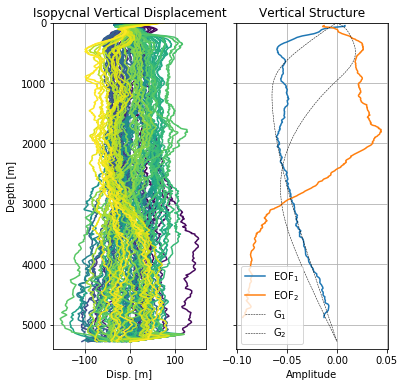

In [11]:
# Displacement EOFs and Displacement Modes 
cmap = plt.cm.get_cmap("viridis", len(mw_eta_3_order[1, :]))
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
for i in range(len(mw_eta_3_order[1, :])):
    ax0.plot(mw_eta_3_order[:, i], grid, color=cmap(i))
ax0.set_ylim([0, 5100])
ax1.plot(UUe[:, 0], grid_check_eta, label=r'EOF$_1$')
ax1.plot(UUe[:, 1], grid_check_eta, label=r'EOF$_2$')
ax1.plot(G_tot[:, 1]/30000, grid, color='k', linestyle='--', linewidth=0.5, label=r'G$_1$')
ax1.plot(-1.0*G_tot[:, 2]/30000, grid, color='k', linestyle='--', linewidth=0.5, label=r'G$_2$')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.set_title('Vertical Structure')
ax1.set_xlabel('Amplitude')
ax0.set_title('Isopycnal Vertical Displacement')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('Disp. [m]')
ax0.set_ylim([0, 5400])
ax1.invert_yaxis()
ax0.grid()
plot_pro(ax1)
f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg037_displacements_eofs.jpg", dpi=300)

In [12]:
# ---- PROJECT MODES ONTO EACH PROFILE -------
# ---- Velocity and Eta (ENERGY)
sz = np.shape(mw_eta_3_good)
num_profs = sz[1]
AG = np.zeros([nmodes, num_profs])
AG_ind = np.zeros([nmodes, len(eta_ind_3[1,:])])
AGz_u = np.zeros([nmodes, np.shape(u)[1]])
AGz_u_F = np.zeros([nmodes, np.shape(u)[1]])
AGz_v = np.zeros([nmodes, np.shape(v)[1]])
AGz_v_F = np.zeros([nmodes, np.shape(v)[1]])

Eta_m = np.nan * np.zeros([np.size(grid), num_profs])
Eta_ind_m = np.nan * np.zeros([np.size(grid), len(eta_ind_3[1,:])])
V_m_u = np.nan * np.zeros([np.size(grid), np.shape(u)[1]])
V_m_u_F = np.nan * np.zeros([np.size(grid), np.shape(u)[1]])
V_m_v = np.nan * np.zeros([np.size(grid), np.shape(v)[1]])
V_m_v_F = np.nan * np.zeros([np.size(grid), np.shape(v)[1]])
Neta = np.nan * np.zeros([np.size(grid), num_profs])
NEta_m = np.nan * np.zeros([np.size(grid), num_profs])
PE_per_mass = np.nan * np.zeros([nmodes, num_profs])
PE_ind_per_mass = np.nan * np.zeros([nmodes, len(eta_ind_3[1,:])])
HKE_per_mass_u = np.nan * np.zeros([nmodes, np.shape(u)[1]])
HKE_per_mass_u_F = np.nan * np.zeros([nmodes, np.shape(u)[1]])
HKE_per_mass_v = np.nan * np.zeros([nmodes, np.shape(v)[1]])
HKE_per_mass_v_F = np.nan * np.zeros([nmodes, np.shape(v)[1]])
modest = np.arange(11, nmodes)
good_ke_prof_u = np.ones(np.shape(u)[1])
good_ke_prof_v = np.ones(np.shape(v)[1])
good_pe_prof = np.ones(num_profs)
HKE_noise_threshold = 1 * 1e-5  # 1e-5
PE_noise_threshold = 1e5

G = G_tot
Gz = Gz_tot
c = c_tot
this_N2 = np.nanmean(N2, axis=1)  
# for i in range(num_profs):
# #     if len(np.intersect1d(d2_winter, i)) | ((mw_prof_good[i] > 60) & (mw_prof_good[i] < 71)):
# #         G = G_0
# #         Gz = Gz_0
# #         c = c_0
# #         this_N2 = np.nanmean(N2[:, 0:4], axis=1)
# #     elif len(np.intersect1d(d2_summer, i)):
# #         G = G_1
# #         Gz = Gz_1
# #         c = c_1
# #         this_N2 = np.nanmean(N2[:, 4:8], axis=1)
# #     else:
# #         G = G_2
# #         Gz = Gz_2
# #         c = c_2
# #         this_N2 = np.nanmean(N2[:, 8:], axis=1)
#     G = G_tot
#     Gz = Gz_tot
#     c = c_tot
#     this_N2 = np.nanmean(N2, axis=1)

# --- U 
for i in range(np.shape(u)[1]):  
    this_V = u[:, i].copy() # SELECT U HERE 
    iv = np.where(~np.isnan(this_V))
    if iv[0].size > 1:
        AGz_u[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(Gz[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
        V_m_u[:, i] = np.squeeze(np.matrix(Gz) * np.transpose(np.matrix(AGz_u[:, i])))
        HKE_per_mass_u[:, i] = (1 / 2) * (AGz_u[:, i] * AGz_u[:, i])
        ival = np.where(HKE_per_mass_u[modest, i] >= HKE_noise_threshold)
        if np.size(ival) > 0:
            good_ke_prof_u[i] = 0  # flag profile as noisy
    else:
        good_ke_prof_u[i] = 0  # flag empty profile as noisy as well
# for i in range(np.shape(u)[1]):  
#     this_V = u[:, i].copy() # SELECT U HERE 
#     iv = np.where(~np.isnan(this_V))
#     if iv[0].size > 1:
#         AGz_u_F[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(F[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
#         V_m_u_F[:, i] = np.squeeze(np.matrix(F) * np.transpose(np.matrix(AGz_u_F[:, i])))
#         HKE_per_mass_u_F[:, i] = (AGz_u_F[:, i] * AGz_u_F[:, i])
              
# --- V         
for i in range(np.shape(v)[1]):         
    this_V = v[:, i].copy() # SELECT V HERE 
    iv = np.where(~np.isnan(this_V))
    if iv[0].size > 1:
        AGz_v[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(Gz[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
        V_m_v[:, i] = np.squeeze(np.matrix(Gz) * np.transpose(np.matrix(AGz_v[:, i])))
        HKE_per_mass_v[:, i] = (1 / 2) * (AGz_v[:, i] * AGz_v[:, i])
        ival = np.where(HKE_per_mass_v[modest, i] >= HKE_noise_threshold)
        if np.size(ival) > 0:
            good_ke_prof_v[i] = 0  # flag profile as noisy
    else:
        good_ke_prof_v[i] = 0  # flag empty profile as noisy as well
# for i in range(np.shape(v)[1]):  
#     this_V = v[:, i].copy() # SELECT U HERE 
#     iv = np.where(~np.isnan(this_V))
#     if iv[0].size > 1:
#         AGz_v_F[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(F[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
#         V_m_v_F[:, i] = np.squeeze(np.matrix(F) * np.transpose(np.matrix(AGz_v_F[:, i])))
#         HKE_per_mass_v_F[:, i] = (AGz_v_F[:, i] * AGz_v_F[:, i])        

# --- eta         
for i in range(np.shape(eta_ind_3[1, :])[0]): 
    # fit to individual eta profiles
    this_eta = eta_ind_3[:, i].copy()  # SELECT ETA HERE 
    # obtain matrix of NEta
    # Neta = this_N2 * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if len(iw) > 1:
        eta_fs = this_eta.copy()  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])        
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        # -- solve matrix problem
        AG_ind[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_ind_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG_ind[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta = this_N2 * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG_ind[:, i]))))
        PE_ind_per_mass[:, i] = (1 / 2) * AG_ind[:, i] * AG_ind[:, i] * c * c

        np.where(PE_ind_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_ind_per_mass[modest, i] >= PE_noise_threshold)
        # if np.size(iwal) > 0:
        #     good_pe_prof[i] = 0  # flag profile as noisy

for i in range(num_profs): 
    # fit to eta profiles
    this_eta = mw_eta_3_good[:, i].copy()  # SELECT ETA HERE 
    # obtain matrix of NEta
    Neta[:, i] = this_N2 * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if len(iw) > 1:
        eta_fs = this_eta.copy()  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])        
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        # -- solve matrix problem
        AG[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta_m[:, i] = this_N2 * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i]))))
        PE_per_mass[:, i] = (1 / 2) * AG[:, i] * AG[:, i] * c * c

        np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        if np.size(iwal) > 0:
            good_pe_prof[i] = 0  # flag profile as noisy            
            
# end loop over each v and eta for fitting

In [34]:
# --- check on mode amplitudes from averaging or individual profiles
# mw_time_ordered_i = np.argsort(mw_time_good)
# AG_ordered = AG[:, mw_time_ordered_i]
# AGz_ordered = AGz[:, mw_time_ordered_i]
# Time_ordered = mw_time_good[mw_time_ordered_i]
# HKE_per_mass = HKE_per_mass[:, mw_time_ordered_i]
# PE_per_mass = PE_per_mass[:, mw_time_ordered_i]
# Info3 = mw_prof_good[mw_time_ordered_i]
# V_ordered = mw_v_good[:, mw_time_ordered_i]
# Vm_ordered = V_m[:, mw_time_ordered_i]
# Eta_ordered = mw_eta_3_good[:, mw_time_ordered_i]  #SELECT ETA AGAIN HERE 
# Etam_ordered = Eta_m[:, mw_time_ordered_i]

In [13]:
# ----------------------------------------------------------------------------------------------------------------------
# --- ENERGY SPECTRA ---
# ----------------------------------------------------------------------------------------------------------------------
# -- initial params
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
dk = f_ref / c_tot[1]
sc_x = 1000 * f_ref / c_tot[1:]

# --- PE, KE selection (exclude eddy)
HKE_per_mass_u_0 = HKE_per_mass_u.copy()
HKE_per_mass_v_0 = HKE_per_mass_v.copy()
PE_per_mass_0 = PE_per_mass.copy()

In [11]:
box_side_info

array([ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

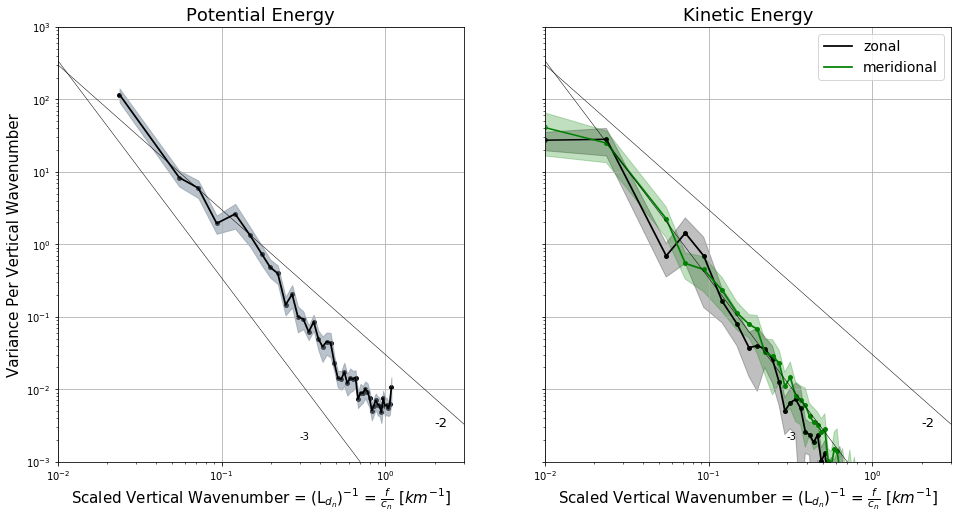

In [14]:
# --- PLOT ENERGY 
matplotlib.rcParams['figure.figsize'] = (16,8)
f_s_en, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
lw = [1.75, 1.75, 1.75, .8]
scz = [15, 15, 15, 6]
# sort_by_uv = [[0,1,2,6,7,8], [3,4,5,9,10,11]] #avg across two u transects and two v transects (will need to update)
# sort_by_uv = [[0,1,2,3,4,5,6,7,8,9,10,11, 6,7,8], [3,4,5,9,10,11]] #avg across two u transects and two v transects (will need to update)
labs = ['zonal', 'meridional']
cols = ['k', 'g']
inn = [np.where((box_side_info == 1) | (box_side_info == 3))[0], np.where((box_side_info == 0) | (box_side_info == 2))[0]]

# confidence intervals
pmean = np.nanmean(PE_per_mass_0[1:, :] / dk, axis=1)
pp = PE_per_mass_0[1:, :] / dk 
pstd = np.nanstd(PE_per_mass_0[1:, :] / dk, axis=1)
low_ci = pmean - 1.960*(pstd/np.sqrt(len(PE_per_mass_0[1, :])))
high_ci = pmean + 1.960*(pstd/np.sqrt(len(PE_per_mass_0[1, :])))

ax1.plot(sc_x, np.nanmean(PE_per_mass_0[1:, :], axis=1) / dk, color=cols[0], label=labs[0], linewidth=lw[0])
ax1.scatter(sc_x, np.nanmean(PE_per_mass_0[1:, :], axis=1) / dk, color=cols[0], s=scz[0])
# ax1.plot(sc_x, low_ci, color='r', linestyle='--', linewidth=0.5)
# ax1.plot(sc_x, high_ci, color='r', linestyle='--', linewidth=0.5)
ax1.fill_between(sc_x, low_ci, high_ci, color='#778899', alpha=0.5) 

# confidence intervals
kumean = np.nanmean(HKE_per_mass_u_0, axis=1) / dk
kup = HKE_per_mass_u_0 / dk 
kustd = np.nanstd(HKE_per_mass_u_0 / dk, axis=1)
low_ci = kumean - 1.960*(kustd/np.sqrt(len(HKE_per_mass_u_0)))
high_ci = kumean + 1.960*(kustd/np.sqrt(len(HKE_per_mass_u_0)))
    
ax2.plot(sc_x, np.nanmean(HKE_per_mass_u_0[1:, :], axis=1) / dk, color=cols[0], label=labs[0], linewidth=lw[0])
ax2.scatter(sc_x, np.nanmean(HKE_per_mass_u_0[1:, :], axis=1) / dk, color=cols[0], s=scz[0])
ax2.plot([10**-2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_u_0, axis=1)[0:2] / dk, color=cols[0], linewidth=1.5)
ax2.scatter(10**-2, np.nanmean(HKE_per_mass_u_0, axis=1)[0] / dk, color=cols[0], s=scz[0]*1.5, facecolors='none')
ax2.fill_between(np.concatenate((np.array([10**-2]), sc_x)), low_ci, high_ci, color=cols[0], alpha=0.25) 

# confidence intervals
kvmean = np.nanmean(HKE_per_mass_v_0, axis=1) / dk
kvp = HKE_per_mass_v_0 / dk 
kvstd = np.nanstd(HKE_per_mass_v_0 / dk, axis=1)
low_ci = kvmean - 1.960*(kvstd/np.sqrt(len(HKE_per_mass_v_0)))
high_ci = kvmean + 1.960*(kvstd/np.sqrt(len(HKE_per_mass_v_0)))

ax2.plot(sc_x, np.nanmean(HKE_per_mass_v_0[1:, :], axis=1) / dk, color=cols[1], label=labs[1], linewidth=lw[1])
ax2.scatter(sc_x, np.nanmean(HKE_per_mass_v_0[1:, :], axis=1) / dk, color=cols[1], s=scz[1])
ax2.plot([10**-2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_v_0, axis=1)[0:2] / dk, color=cols[1], linewidth=1.5)
ax2.scatter(10**-2, np.nanmean(HKE_per_mass_v_0, axis=1)[0] / dk, color=cols[1], s=scz[1]*1.5, facecolors='none')
ax2.fill_between(np.concatenate((np.array([10**-2]), sc_x)), low_ci, high_ci, color=cols[1], alpha=0.25) 
    
# modeno = '1', '2', '3', '4', '5', '6', '7', '8'   
# for i in range(len(modeno)):
#     ax1.text(sc_x[i], (np.nanmean(PE_per_mass_0[i + 1, bckgrds[0]]) / dk) + 
#              (np.nanmean(PE_per_mass_0[i + 1, bckgrds[0]]) / dk)/7, modeno[i], color=cols[0])    
# -- GM
# ax1.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * PE_GM_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
# ax1.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * PE_GM_bats[1] / sta_bats_dk, r'$1/4 PE_{GM}$', fontsize=10)
# ax2.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * GMKE_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
# ax2.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * GMKE_bats[1] / sta_bats_dk, r'$1/4 KE_{GM}$', fontsize=10)    
ax1.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax1.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax1.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax1.text(2*10**0, 3*10**-3, '-2', fontsize=13)
ax2.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax2.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax2.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax2.text(2*10**0, 3*10**-3, '-2', fontsize=13)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=14)
ax1.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=15)
ax1.set_ylabel('Variance Per Vertical Wavenumber', fontsize=15)
ax1.set_title('Potential Energy', fontsize=18)
ax1.set_xlim([10 ** -2, 3 * 10 ** 0])
ax1.set_ylim([10 ** (-3), 1 * 10 ** 3])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=15)
ax2.set_title('Kinetic Energy', fontsize=18)
ax2.set_xlim([10 ** -2, 3 * 10 ** 0])
ax2.set_xscale('log')
ax1.grid()
plot_pro(ax2)
f_s_en.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_09_04/sg037_pe_ke.jpg", dpi=300)

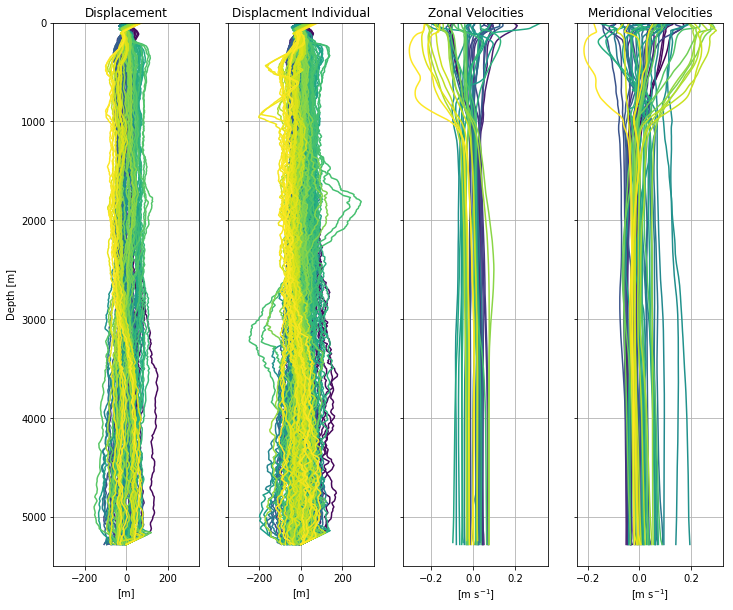

In [15]:
matplotlib.rcParams['figure.figsize'] = (12, 10)
cmap = plt.cm.get_cmap("viridis", len(mw_eta_3_order[1, :]))
f, (ax, ax1, ax2, ax3) = plt.subplots(1, 4, sharey=True)
for i in range(len(mw_eta_3_order[1, :])):
    ax.plot(mw_eta_3_order[:, i], grid, color=cmap(i))
ax.set_ylim([0, 5100])

cmap = plt.cm.get_cmap("viridis", len(eta_ind_3[1, :]))
for i in range(len(eta_ind_3[1, :])):
    ax1.plot(eta_ind_3[:, i], grid, color=cmap(i))

cmap = plt.cm.get_cmap("viridis", len(u[1, :]))
for i in range(len(u[1, :])):
    ax2.plot(u[:, i], grid, color=cmap(i))

cmap = plt.cm.get_cmap("viridis", len(v[1, :]))
for i in range(len(v[1, :])):
    ax3.plot(v[:, i], grid, color=cmap(i)) 

ax.grid()
ax.set_title('Displacement')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('[m]')
ax.set_ylim([0, 5500])
ax.set_xlim([-350, 350])
ax1.grid()
ax1.set_title('Displacment Individual')
ax1.set_xlabel('[m]')
ax1.set_xlim([-350, 350])
ax2.grid()
ax2.set_title('Zonal Velocities')
ax2.set_xlabel(r'[m s$^{-1}$]')
ax3.set_title('Meridional Velocities')
ax3.set_xlabel(r'[m s$^{-1}$]')
ax3.invert_yaxis()    
plot_pro(ax3)
f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_lde_eta_v.jpg", dpi=300)

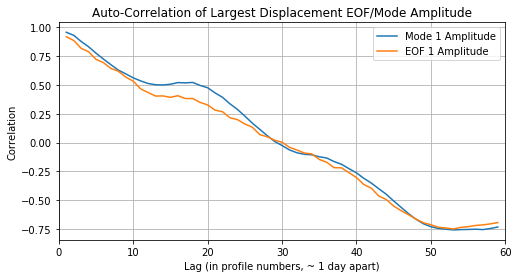

()

In [16]:
# Take EOF amplitude (a function of time) and at each time step ask 
# which combination of mode amplitudes is required to reproduce EOF 

def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

Amp1_eta = VVe[0, :]*SSe[0]
Amp2_eta = VVe[1, :]*SSe[1]

result = np.correlate(AG_ind[1, :], AG_ind[1, :], mode='full')
zrr = result[result.size // 2:]
result2 = np.correlate(Amp1_eta, Amp1_eta, mode='full')
zrr2 = result[result2.size // 2:]

test = np.nan * np.ones((60, 2))
for i in range(1, 60):
    outt = autocorr(AG_ind[1, :], t=i)
    test[i, 0] = outt[0, 1]
    outt2 = autocorr(Amp1_eta, t=i)
    test[i, 1] = outt2[0, 1]

matplotlib.rcParams['figure.figsize'] = (8, 4)
f, ax = plt.subplots()
# plt.acorr(AG_ind[1, :], maxlags=60)
ax.plot(test[:, 0], label='Mode 1 Amplitude')
ax.plot(test[:, 1], label='EOF 1 Amplitude')
ax.set_xlim([0, 60])
ax.set_xlabel('Lag (in profile numbers, ~ 1 day apart)')
ax.set_ylabel('Correlation')
ax.set_title('Auto-Correlation of Largest Displacement EOF/Mode Amplitude')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
plot_pro(ax)
# f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_lde_eta_auto_corr.jpg", dpi=300)

1

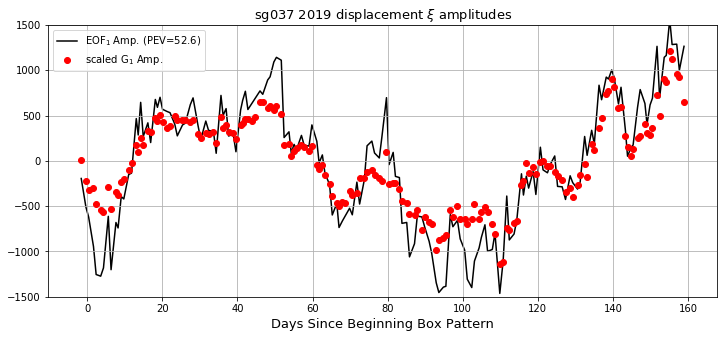

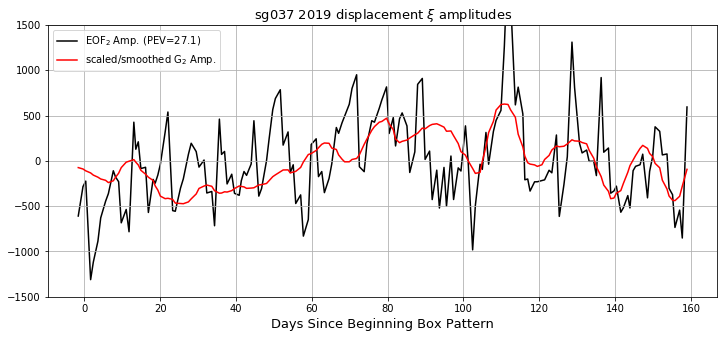

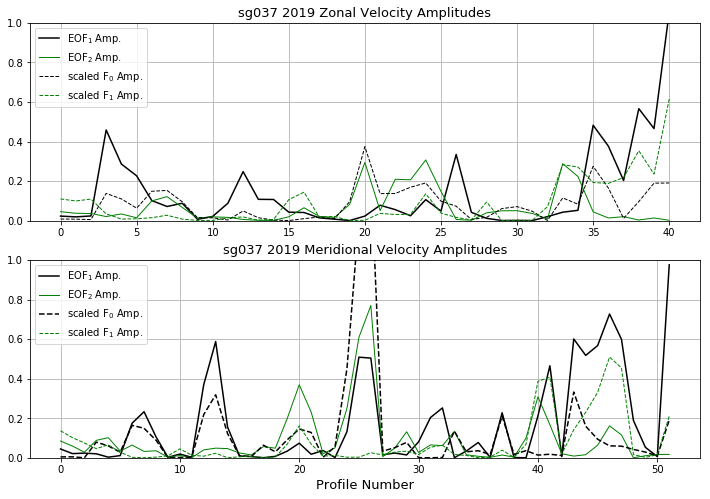

In [41]:
Amp1_u = (VV[0, :]*SS[0])**2
Amp2_u = (VV[1, :]*SS[1])**2
Amp3_u = (VV[2, :]*SS[2])**2
Amp1_v = (VV2[0, :]*SS2[0])**2
Amp2_v = (VV2[1, :]*SS2[1])**2
Amp3_v = (VV2[2, :]*SS2[2])**2

day_count = mw_time_order - np.nanmin(mw_time_good)

matplotlib.rcParams['figure.figsize'] = (12, 5)
f0, ax0 = plt.subplots()
ax0.plot(eta_ind_time - np.nanmin(mw_time_good), Amp1_eta, color='k', label=r'EOF$_1$ Amp. (PEV=' + str(np.round(frac_eof_eta[0]*100,1)) + ')', zorder=1)
ax0.scatter(prof_time - np.nanmin(mw_time_good), 20000*AG_ind[1, :], color='r', label=r'scaled G$_1$ Amp.', zorder=2)
ax0.set_ylim([-1500, 1500])
ax0.set_title(r'sg037 2019 displacement $\xi$ amplitudes', fontsize=13)
ax0.set_xlabel('Days Since Beginning Box Pattern', fontsize=13)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=10)
plot_pro(ax0)
# f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_lde_eta_eof_mode_amps.jpg", dpi=300)

from scipy.signal import savgol_filter
yhat = savgol_filter(-20000.0*AG_ind[2, :], 15, 3)

matplotlib.rcParams['figure.figsize'] = (12, 5)
f, ax0 = plt.subplots()
ax0.plot(eta_ind_time - np.nanmin(mw_time_good), Amp2_eta, color='k', label=r'EOF$_2$ Amp. (PEV=' + str(np.round(frac_eof_eta[1]*100,1)) + ')', zorder=1)
# ax0.scatter(prof_time - np.nanmin(mw_time_good), -20000.0*AG_ind[2, :], color='r', label=r'scaled G$_2$ Amp.', zorder=2)
ax0.plot(prof_time - np.nanmin(mw_time_good), yhat, color='r', zorder=2, label=r'scaled/smoothed G$_2$ Amp.')
ax0.set_ylim([-1500, 1500])
ax0.set_title(r'sg037 2019 displacement $\xi$ amplitudes', fontsize=13)
ax0.set_xlabel('Days Since Beginning Box Pattern', fontsize=13)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=10)
plot_pro(ax0)

uv_times_ordered = np.argsort(uv_times)
Amp1_uv = np.concatenate((Amp1_u, Amp1_v), axis=0)
Amp2_uv = np.concatenate((Amp2_u, Amp2_v), axis=0)
Amp3_uv = np.concatenate((Amp3_u, Amp3_v), axis=0)
AGz1_uv = np.concatenate((AGz_u[0, :], AGz_v[0, :]), axis=0)
AGz2_uv = np.concatenate((AGz_u[1, :], AGz_v[1, :]), axis=0)
AGz3_uv = np.concatenate((AGz_u[2, :], AGz_v[2, :]), axis=0)
Amp1_uv_ordered = Amp1_uv[uv_times_ordered]
Amp2_uv_ordered = Amp2_uv[uv_times_ordered]
Amp3_uv_ordered = Amp3_uv[uv_times_ordered]
AGz1_uv_ordered = AGz1_uv[uv_times_ordered]
AGz2_uv_ordered = AGz2_uv[uv_times_ordered]
AGz3_uv_ordered = AGz3_uv[uv_times_ordered]

# def mode_cont(p, Amp1, AGz_u1, AGz_u2):
#     #  This is the target function that needs to be minimized
#     fsq = (Amp1 - (p[0]*(AGz_u1**2) + p[1]*(AGz_u2**2)))**2
#     return (fsq.sum())

# min_p1 = np.nan * np.ones((len(Amp1_u), 2))
# for i in range(len(Amp1_u)):
# #     inputs = np.transpose(np.concatenate([np.transpose(Amp1_u[i])[:, None], 
# #                                           np.transpose(AGz_u[0, i])[:, None], 
# #                                           np.transpose(AGz_u[1, i])[:, None]], axis=1))
#     inputs = np.array([Amp1_u[i], AGz_u[0, i], AGz_u[1, i]])
#     init_guess = np.array([10, 10])
#     min_p1[i, :] = fmin(mode_cont, init_guess, args=(tuple(inputs)), disp=0)

matplotlib.rcParams['figure.figsize'] = (12, 8)
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(np.arange(len(Amp1_u)), 0.15*Amp1_u, linewidth=1.5, label=r'EOF$_1$ Amp.', color='k')
ax1.plot(np.arange(len(Amp2_u)), 0.15*Amp2_u, linewidth=1, label=r'EOF$_2$ Amp.', color='g')
ax1.plot(np.arange(len(Amp1_u)), 65.0*AGz_u[0, :]**2, linewidth=1, label=r'scaled F$_0$ Amp.', color='k', linestyle='--')
ax1.plot(np.arange(len(Amp1_u)), 65.0*AGz_u[1, :]**2, linewidth=1, label=r'scaled F$_1$ Amp.', color='g', linestyle='--')

ax2.plot(np.arange(len(Amp1_v)), 0.15*Amp1_v, linewidth=1.5, label=r'EOF$_1$ Amp.', color='k')
ax2.plot(np.arange(len(Amp2_v)), 0.15*Amp2_v, linewidth=1, label=r'EOF$_2$ Amp.', color='g')
ax2.plot(np.arange(len(Amp1_v)), 65.0*AGz_v[0, :]**2, linewidth=1.5, label=r'scaled F$_0$ Amp.', color='k', linestyle='--')
ax2.plot(np.arange(len(Amp1_v)), 65.0*AGz_v[1, :]**2, linewidth=1, label=r'scaled F$_1$ Amp.', color='g', linestyle='--')

ax1.grid()
ax1.set_title('sg037 2019 Zonal Velocity Amplitudes', fontsize=13)
ax2.set_title('sg037 2019 Meridional Velocity Amplitudes', fontsize=13)
ax2.set_xlabel('Profile Number', fontsize=13)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10)
ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])
plot_pro(ax2)

f0.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_lde_eta_eof_mode2_amps.jpg", dpi=300)
f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_lde_vel_eof_mode_amps.jpg", dpi=300)

In [36]:
min_p1

array([[  2.61675826e+01,   8.81450513e+01],
       [  2.40166125e+01,   8.02578290e+01],
       [  2.53934110e+01,   9.21507517e+01],
       [  1.37944957e+03,   2.65003937e+02],
       [  1.11489433e+03,   2.14455015e+02],
       [  1.51732829e+03,   2.88398456e+02],
       [  2.89065201e+02,   6.14238737e+01],
       [  1.94607640e+02,   4.49058681e+01],
       [  3.93434339e+02,   7.93429858e+01],
       [  1.88558679e+02,   4.30404786e+01],
       [  6.42976541e+02,   1.30266654e+02],
       [  5.02657502e+02,   2.65731406e+03],
       [  2.05340940e+03,   3.90292262e+02],
       [  3.13608947e+03,   5.88594403e+02],
       [  1.35599247e+03,   7.24852319e+03],
       [  4.12197448e+01,   1.74266831e+02],
       [  3.06604496e+01,   1.21127183e+02],
       [  5.89401882e+01,   2.72692531e+02],
       [  3.29791343e+01,   1.33187863e+02],
       [  1.30074426e+00,   1.13227542e+01],
       [  2.63154900e+01,   1.25392665e+01],
       [  2.32130211e+02,   5.31805123e+01],
       [  

In [31]:
time_since = np.arange(0, 130, 2)
test_amp = 100.0*np.ones(len(time_since)) + np.random.random(len(time_since))
g1_amp = np.interp(time_since, prof_time - np.nanmin(mw_time_good), -5500*AG_ind[1, :]) + 0*np.random.random(len(time_since))
g2_amp = np.interp(time_since, prof_time - np.nanmin(mw_time_good), -5500*(AG_ind[1, :] - AG_ind[2, :]))
eof1_amp = np.interp(time_since, eta_ind_time - np.nanmin(mw_time_good), Amp1_eta)
eof2_amp = np.interp(time_since, eta_ind_time - np.nanmin(mw_time_good), Amp1_eta + Amp2_eta)
# f, ax = plt.subplots()
# ax.plot(time_since, g1_amp)
# ax.plot(time_since, eof1_amp)
# plot_pro(ax)
np.corrcoef(g1_amp, eof1_amp)

array([[ 1.        , -0.93141076],
       [-0.93141076,  1.        ]])

In [21]:
np.shape(AG_ind)
datetime.date.fromordinal(np.int(eta_ind_time[0]))

datetime.date(2019, 7, 8)

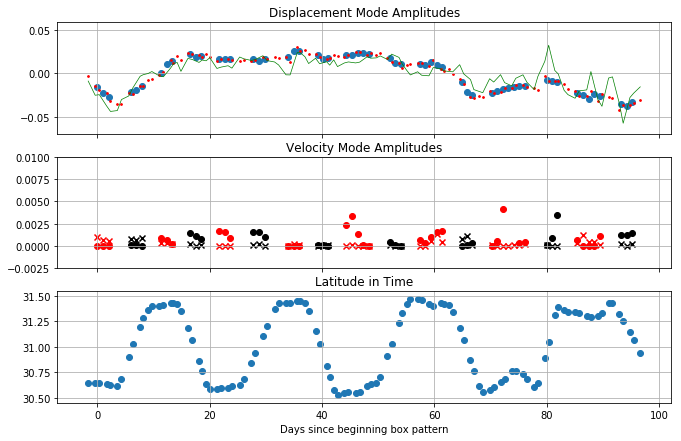

()

In [43]:
matplotlib.rcParams['figure.figsize'] = (11, 7)
f, (ax0, ax, ax1) = plt.subplots(3, 1, sharex=True)
ax0.scatter(mw_time_order - np.nanmin(mw_time_good), AG[1, time_order_i])
ax0.scatter(prof_time - np.nanmin(mw_time_good), AG_ind[1, :], color='r', s=3)
ax0.plot(prof_time - np.nanmin(mw_time_good), AG_ind[3, :], color='g', linewidth=0.7)

ax.scatter(u_time - np.nanmin(mw_time_good), HKE_per_mass_u_0[0, :], color='k')
ax.scatter(v_time - np.nanmin(mw_time_good), HKE_per_mass_v_0[0, :], color='r')
ax.scatter(u_time - np.nanmin(mw_time_good), HKE_per_mass_u_0[1, :], color='k', marker='x')
ax.scatter(v_time - np.nanmin(mw_time_good), HKE_per_mass_v_0[1, :], color='r', marker='x')

ax1.scatter(prof_time - np.nanmin(mw_time_good), np.nanmean(prof_lat, axis=0))

ax0.grid()
ax0.set_title('Displacement Mode Amplitudes')
ax.set_ylim([-.0025, 0.01])
ax.set_title('Velocity Mode Amplitudes')
ax1.set_title('Latitude in Time')
ax1.set_xlabel('Days since beginning box pattern')
ax.grid()
plot_pro(ax1)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_09_04/sg037_mode_amps.jpg", dpi=300)

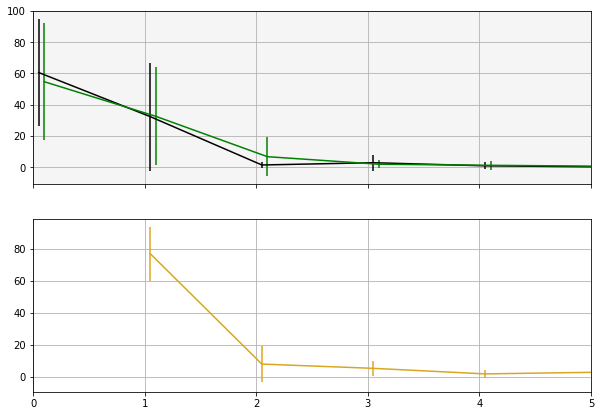

()

In [14]:
# Fraction of energy in each mode 
KE_u_fraction = 100 * HKE_per_mass_u_0 / np.tile(np.nansum(HKE_per_mass_u_0, axis=0), (nmodes, 1))
KE_u_std = np.nanstd(KE_u_fraction, axis=1)
KE_v_fraction = 100 * HKE_per_mass_v_0 / np.tile(np.nansum(HKE_per_mass_v_0, axis=0), (nmodes, 1))
KE_v_std = np.nanstd(KE_v_fraction, axis=1)
PE_fraction = 100 * PE_per_mass_0 / np.tile(np.nansum(PE_per_mass_0, axis=0), (nmodes, 1))
PE_std = np.nanstd(PE_fraction, axis=1)

cols = ['k', 'g', '#DAA520', '#800080']
matplotlib.rcParams['figure.figsize'] = (10,7)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_facecolor('#F5F5F5')
ax1.errorbar(np.arange(0, nmodes) + 0.05, np.nanmean(KE_u_fraction, axis=1), yerr=KE_u_std, color=cols[0], label='KE_u')
ax1.errorbar(np.arange(0, nmodes) + .1, np.nanmean(KE_v_fraction, axis=1), yerr=KE_v_std, color=cols[1], label='KE_v')
ax2.errorbar(np.arange(1, nmodes) + .05, np.nanmean(PE_fraction[1:, :], axis=1), yerr=PE_std[1:], color=cols[2], label='PE')
ax2.set_xlim([0, 5])
ax1.grid()
plot_pro(ax2)

In [55]:

print(np.nanmean(PE_fraction[0:4], axis=1))
print(np.sum(np.nanmean(PE_fraction[0:4], axis=1)))
# print(epsilon_tot[1, 1, 1])
# print(epsilon_tot[2, 2, 2])
# print(epsilon_tot[3, 3, 3])

[  0.          70.17416117  12.94961731   5.26647402]
88.3902524957


In [15]:
# surface kinetic energy 
# temporal orthogonality of the modes 
uv_times = np.concatenate((u_time, v_time), axis=0)
uv_times_ordered = np.argsort(uv_times)
AGz_uv = np.concatenate((AGz_u, AGz_v), axis=1)
AGz_uv_ordered = AGz_uv[:, uv_times_ordered]
L = len(AGz_uv_ordered[0, :])
mm = np.nan * np.ones((L, len(grid), np.shape(AGz_uv_ordered)[0]))
mm2 = np.nan * np.ones((L, len(grid), np.shape(AGz_uv_ordered)[0]))
for j in range(L):  # loop over each time 
    for i in range(np.shape(AGz_uv_ordered)[0]):  # loop over each mode 
        mm[j, :, i] = AGz_uv_ordered[i, j]*Gz[:, i]
        mm2[j, :, i] = (AGz_uv_ordered[i, j]**2)*(Gz[:, i]**2)
    
# outer mean is avg across time ( inner sum is acoss modes)    
T_1 = np.nanmean(np.squeeze(np.nansum(mm, axis=2)**2), axis=0) 
# outer mean is avg across time
T_2 = np.nanmean(mm2, axis=0)
T_2_check = np.nanmean(np.nansum(mm2, axis=2), axis=0)

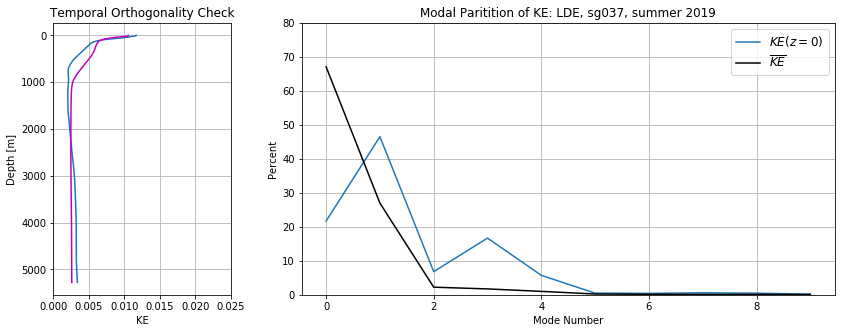

()

In [23]:
from matplotlib import gridspec
fig0 = plt.figure(figsize=(14, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
ax0 = plt.subplot(gs[0])
ax = plt.subplot(gs[1])

ax0.plot(T_1, grid)
ax0.plot(T_2_check, grid, color='m')
ax0.set_xlim([0, 0.025])
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('KE')
ax0.set_title('Temporal Orthogonality Check')
ax0.invert_yaxis()
ax0.grid()

ax.plot(np.arange(0, 10), 100*T_2[0, 0:10]/np.nansum(T_2[0, :]), label=r'$KE(z=0)$')
T_2_mean = np.nanmean(T_2, axis=0)
ax.plot(np.arange(0, 10), 100*(T_2_mean[0:10]/np.nansum(T_2_mean)), color='k', label=r'$\overline{KE}$')
ax.set_xlabel('Mode Number')
ax.set_ylabel('Percent')
ax.set_title('Modal Paritition of KE: LDE, sg037, summer 2019')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=12)
ax.set_ylim([0, 80])
plot_pro(ax)
# fig0.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_lde_surface_ke.jpg", dpi=300)

In [75]:
np.sum(100*T_2[0, 0:5]/np.nansum(T_2[0, :]))
T_2_check

array([  1.55167684e-02,   1.54734208e-02,   1.53006410e-02,
         1.45769596e-02,   1.30006295e-02,   1.15049831e-02,
         1.09071362e-02,   1.04289714e-02,   9.40012804e-03,
         8.27466340e-03,   7.48510761e-03,   7.05092366e-03,
         6.86922883e-03,   6.82057630e-03,   6.84443414e-03,
         6.90919091e-03,   6.96192957e-03,   6.92378997e-03,
         6.73993029e-03,   6.39715588e-03,   5.92189281e-03,
         5.37204644e-03,   4.79580158e-03,   4.22716090e-03,
         3.67835066e-03,   3.13676417e-03,   2.60202269e-03,
         2.09070106e-03,   1.62148640e-03,   1.21532592e-03,
         7.92625875e-04,   3.59277077e-04,  -2.08113912e-05,
        -3.79412320e-04,  -7.10408918e-04,  -1.01276081e-03,
        -1.29300077e-03,  -1.55568551e-03,  -1.79823666e-03,
        -2.02338804e-03,  -2.23060360e-03,  -2.42312631e-03,
        -2.60666318e-03,  -2.78105404e-03,  -2.94931661e-03,
        -3.10984960e-03,  -3.26193130e-03,  -3.40862482e-03,
        -3.54910716e-03,

In [32]:
PE_SD, PE_GM, GMPE, GMKE, n_cross_dep = PE_Tide_GM(rho0, grid, nmodes, np.transpose(np.atleast_2d(np.nanmean(N2, axis=1))), f_ref)

savee = 1
if savee > 0:
    my_dict = {'depth': grid, 'c': c_tot, 'f': f_ref, 'N2_per': N2,
               'PE_all': PE_per_mass_0, 'KE_u_all': HKE_per_mass_u_0, 'KE_v_all': HKE_per_mass_v_0,
               'PE_per_prof_all': PE_per_prof_time, 'PE_per_prof_ind': PE_per_prof_tag,
               'GMPE': GMPE, 'GMKE': GMKE,
               'epsilons_per_season': epsilon_tot}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg037_2019_energy_dec_08_2019.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()

In [21]:
n_cross_dep

868.03322911596808

In [ ]:
# EDDY!!!
matplotlib.rcParams['figure.figsize'] = (12, 8)
f, (ax, ax2, ax3) = plt.subplots(1, 3, sharey=True)
cmap = plt.cm.get_cmap("plasma", 9)
indis = range(117, 128)
for i in range(len(indis)):
    ax.plot(eta_ind_3[:, indis[i]], grid, color=cmap(i))
    ax2.plot(sa[:, indis[i]], grid, color=cmap(i))
    ax3.plot(ct[:, indis[i]], grid, color=cmap(i))
ax.set_ylim([0, 5500])
ax.invert_yaxis()
ax.set_xlim([-350, 350])
ax.set_title('Displacement')
ax.set_ylabel('Depth')
ax2.set_xlim([35, 35.4])
ax2.set_title('Absolute Salinity')
ax3.set_xlim([1, 7])
ax3.set_title('Cons. Temperature')
ax.grid()
ax2.grid()
plot_pro(ax3)
# f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_lde_eddy.jpg", dpi=400)

f, ax = plt.subplots()
for i in range(len(indis)):
    ax.scatter(sa[:, indis[i]], ct[:, indis[i]], color=cmap(i), s=7)
ax.plot(np.nanmean(sa[:, 121:123], axis=1), np.nanmean(ct[:, 121:123], axis=1), color='g', linewidth=1.5)
ax.plot(np.nanmean(sa[:, 100:], axis=1), np.nanmean(ct[:, 100:], axis=1), color='k')
ax.set_xlim([35, 35.4])
ax.set_ylim([1, 7])   
ax.set_xlabel('Absolute Salinity')
ax.set_ylabel('Cons. Temperature')
plot_pro(ax)   
# f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_lde_eddy_ts.jpg", dpi=400)